The powerful histogramming package for Python, boost-histogram 0.6.0 was released! This is a major update to the new Boost.Histogram bindings. Since I have not written over boost-histogram yet here, I will introduce the library in it's current state. Version 0.6.0 is based on the soon-to-be released Boost libraries 1.72 Histogram package.

The key design feature of the boost-histogram package (and the C++ library on which it is based) is the idea of a configurable Histogram object. A histogram is made of two things: a **storage** and a collection of **axes**.

There are a preset collection of storages in boost-histogram, with different datatypes. Storages can hold simple data types (`Int64`, `Double`, and `AtomicInt64`), a special mutating `Unlimited` datatype that starts as an 8 bit int and grows, and even converts to double if weights are used (or, currently, if a view is requested). There are also several **accumulators**. You can use `WeightedSum` to track a error (like [ROOT](https://root.cern)), or `Mean`/`WeightedMean` to implement a "profile" histogram.

Axes come in a variety of flavors. `Regular` provides even bin spacings, `Variable` provides arbitrary bin spacings, `Integer` is a high performance simple integer spacing, and `IntCategory`/`StrCategory` provide arbitrary non-continuous categories. Each of these has options, such as `growth=`, which allows the axis to grow when out-of-range fills are made, `overflow=` and `underflow=`, which hold out-of-range fills on continuous axes, and `circular=`, which causes an axis to wrap around. The `Regular` axis also supports **transforms**, which map values in and out of the regular binning space. A few common transforms are provides, such as `Pow(v)`, `sqrt`, and `log`, and users can supply a pair of CTypes function pointers to build new transforms with full performance. Feel free to use `@numba.cfunc` to write your transforms directly in Python!

Let's take a look at what using the library looks like. Let's start with a simple, contrived 1D dataset:

In [2]:
import numpy as np
import boost_histogram as bh
import matplotlib.pyplot as plt

In [3]:
norm_vals = np.concatenate(
    [
        np.random.normal(loc=5, scale=1, size=1_000_000),
        np.random.normal(loc=2, scale=0.2, size=200_000),
        np.random.normal(loc=8, scale=0.2, size=200_000),
    ]
)

You start by making a histogram with one axis. The "Double" storage is default, since it is more flexible and just as fast and 64-bit integers, and can be filled with up to 53 bits of integer information.

In [3]:
hist = bh.Histogram(
    bh.axis.Regular(100, 0, 10),
)

Now we can fill the histogram with our dataset:

In [4]:
hist.fill(norm_vals)

Histogram(Regular(100, 0, 10), storage=Double()) # Sum: 1400000.0

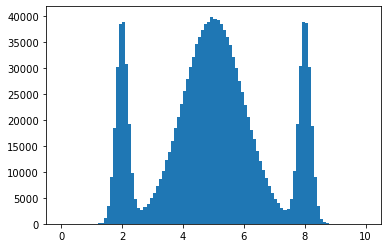

In [6]:
plt.bar(*hist.axes.centers, hist, *hist.axes.widths)
plt.savefig("../static/post/boost-histogram-060/images/1d_histogram.png")

#### Performance: Regular

In [138]:
%%timeit
hist.reset()
hist.fill(norm_vals)

7.17 ms ± 97.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [139]:
%%timeit
np.histogram(norm_vals, bins=100, range=(0, 10))

17.4 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [140]:
%%timeit
bh.numpy.histogram(norm_vals, bins=100, range=(0, 10))

7.3 ms ± 55.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Smart binning

In [142]:
%%timeit
np.histogram(norm_vals, bins="auto")

42.9 ms ± 568 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [143]:
%%timeit
bh.numpy.histogram(norm_vals, bins="auto")

66.3 ms ± 682 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Performance: Variable edges

In [115]:
(e,) = hist.axes.edges

In [116]:
histV = bh.Histogram(
    bh.axis.Variable(e),
)

In [117]:
%%timeit
histV.reset()
histV.fill(norm_vals)

31.6 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [118]:
%%timeit
np.histogram(norm_vals, bins=e)

89.1 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [119]:
%%timeit
bh.numpy.histogram(norm_vals, bins=e)

30.5 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Integer filling

In [127]:
histI = bh.Histogram(
    bh.axis.Integer(0, 10),
)

In [128]:
%%timeit
histI.reset()
histI.fill(norm_vals)

4.83 ms ± 20 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Log axes plotting

In [7]:
hist = bh.Histogram(
    bh.axis.Regular(100, 1, 10, transform=bh.axis.transform.log),
)

hist.fill(norm_vals)

Histogram(Regular(100, 1, 10, transform=log), storage=Double()) # Sum: 1399958.0 (1400000.0 with flow)

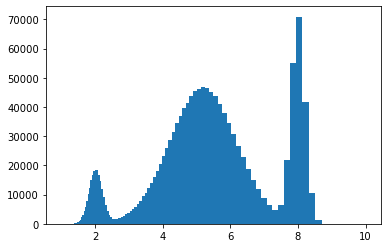

In [8]:
plt.bar(*hist.axes.centers, hist, *hist.axes.widths);

While boost-histogram does not currently have a "density" method, you can easily compute a density given the tools provided:

In [9]:
volumes = np.prod(hist.axes.widths, axis=0)
density = hist.view() / hist.sum() / volumes

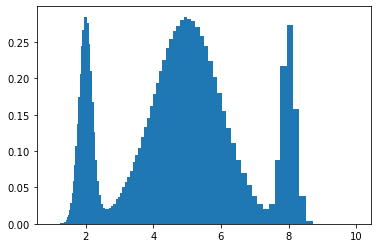

In [10]:
plt.bar(*hist.axes.centers, density, *hist.axes.widths)
plt.savefig("../static/post/boost-histogram-060/images/1d_histogram_log.png")

In [84]:
h2 = bh.Histogram(bh.axis.Regular(400, -2, 2), bh.axis.Regular(200, -1, 1))

data = np.random.multivariate_normal((0, 0), ((1, 0), (0, 0.5)), 10_000_000).T.copy()

h2.fill(*data)

Histogram(
  Regular(400, -2, 2),
  Regular(200, -1, 1),
  storage=Double()) # Sum: 8042255.0 (10000000.0 with flow)

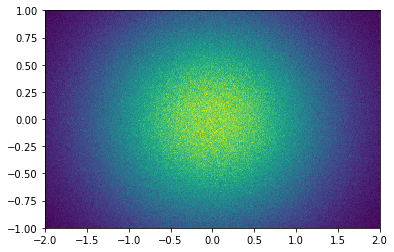

In [85]:
x, y = h2.axes.edges
plt.pcolormesh(x.T, y.T, h2.view().T)

plt.savefig("../static/post/boost-histogram-060/images/2d_histogram.png")

In [21]:
%%timeit
np.histogram2d(*data, bins=(400, 200), range=((-2, 2), (-1, 1)))

1.31 s ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
bh.numpy.histogram2d(*data, bins=(400, 200), range=((-2, 2), (-1, 1)))

101 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
hm = bh.Histogram(
    bh.axis.Regular(20, -1, 1, underflow=False, overflow=False),
    storage=bh.storage.Mean(),
)

In [5]:
data = np.random.multivariate_normal(
    (0, 1), ((0.1, 0.3), (0.3, 1.0)), size=10_000
).T.copy()

In [6]:
hm.fill(data[0], sample=data[1])

Histogram(Regular(20, -1, 1, underflow=False, overflow=False), storage=Mean()) # Sum: Mean(count=9982, value=0.986308, variance=0.106716)

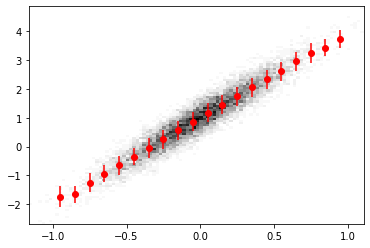

In [16]:
fig, ax = plt.subplots()
ax.hist2d(*data, bins=100, cmap="gray_r")
ax.errorbar(
    hm.axes[0].centers, hm.view()["value"], yerr=np.sqrt(hm.view().variance), fmt="ro"
)
plt.savefig("../static/post/boost-histogram-060/images/profile_histogram.png")